In [1]:
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import snapatac2 as snap
import numpy as np
import pandas as pd
import os
import scanpy.external as sce
#adata_concat = snap.read_dataset('output/motif/motif/motif/motif/motif/mouse_brain.h5ads')

In [2]:
file = "/data2st1/junyi/output/mouse_brain_dar.h5ad"

In [3]:
adata = anndata.read_h5ad(file)

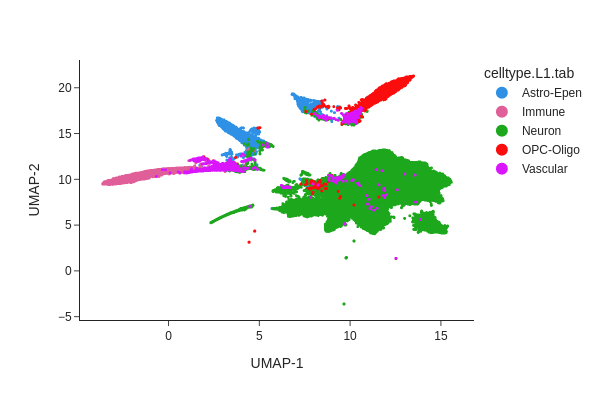

In [4]:
snap.pl.umap(adata, color="celltype.L1.tab", interactive=False,  marker_size=3)


In [5]:
celltypes = adata.obs["celltype.L1.tab"].unique()
region = ['AMY','HIP','PFC']
print(celltypes)
print(region)

['Neuron', 'Astro-Epen', 'OPC-Oligo', 'Immune', 'Vascular']
Categories (5, object): ['Astro-Epen', 'Immune', 'Neuron', 'OPC-Oligo', 'Vascular']
['AMY', 'HIP', 'PFC']


In [6]:
region = 'PFC'
celltype = 'Neuron'
base_name = f"{region}_{celltype}"

In [7]:
adata_AMY_neuron = adata[(adata.obs['sample'].str.contains(region)) & (adata.obs['celltype.L1.tab'].str.contains(celltype)) ].copy()
adata_AMY_neuron


AnnData object with n_obs × n_vars = 25698 × 526402
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'macs3', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_spectral_mnn', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [8]:
adata_AMY_neuron.obs['expriment'] = adata_AMY_neuron.obs['sample'].str[:2]


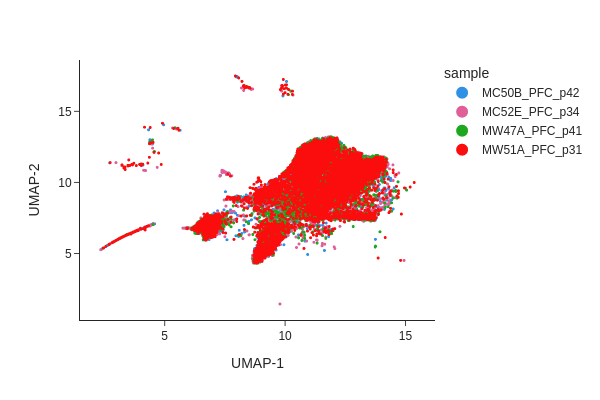

In [9]:
snap.pl.umap(adata_AMY_neuron, color="sample", interactive=False,  marker_size=3)


In [10]:
%%time
snap.tl.macs3(adata_AMY_neuron, groupby='expriment')


2025-03-05 17:06:39 - INFO - Exporting fragments...
2025-03-05 17:14:54 - INFO - Calling peaks...
100%|██████████| 2/2 [58:51<00:00, 1765.56s/it]


CPU times: user 11min 12s, sys: 13min 20s, total: 24min 33s
Wall time: 1h 7min 8s


In [11]:
adata_AMY_neuron

AnnData object with n_obs × n_vars = 25698 × 526402
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab', 'expriment'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'macs3', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_spectral_mnn', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [12]:
%%time
peaks = snap.tl.merge_peaks(adata_AMY_neuron.uns['macs3'], snap.genome.GRCm39)
peaks.head()


CPU times: user 4.58 s, sys: 1.19 s, total: 5.77 s
Wall time: 1.35 s


Peaks,MW,MC
str,bool,bool
"""chr1:3051678-3052179""",true,true
"""chr1:3055677-3056178""",true,true
"""chr1:3165199-3165700""",true,true
"""chr1:3183734-3184235""",true,true
"""chr1:3189956-3190457""",true,true


In [13]:
%%time
peak_mat = snap.pp.make_peak_matrix(adata_AMY_neuron, use_rep=peaks['Peaks'])
peak_mat


CPU times: user 17min 45s, sys: 4min 23s, total: 22min 8s
Wall time: 32.4 s


AnnData object with n_obs × n_vars = 25698 × 364487
    obs: 'sample', 'sample_barcode', 'obs_names', 'celltype.L2.p', 'celltype.L1.p', 'leiden', 'celltype.L1.GBoost', 'celltype.L1.tab', 'expriment'

In [14]:
peak_mat.layers['raw'] = peak_mat.X.copy()

In [15]:
sc.pp.normalize_total(peak_mat)

In [16]:
sc.pp.log1p(peak_mat)

In [17]:
%%time
sc.tl.rank_genes_groups(peak_mat, groupby='expriment', method='wilcoxon',pts=True)

... storing 'expriment' as categorical
/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.



CPU times: user 12min 2s, sys: 2min 11s, total: 14min 13s
Wall time: 10min 37s


In [18]:
peak_mat.obsm['X_umap'] = adata_AMY_neuron.obsm['X_umap']

In [19]:
peak_mat.write(f"output/motif/{base_name}.h5ads")

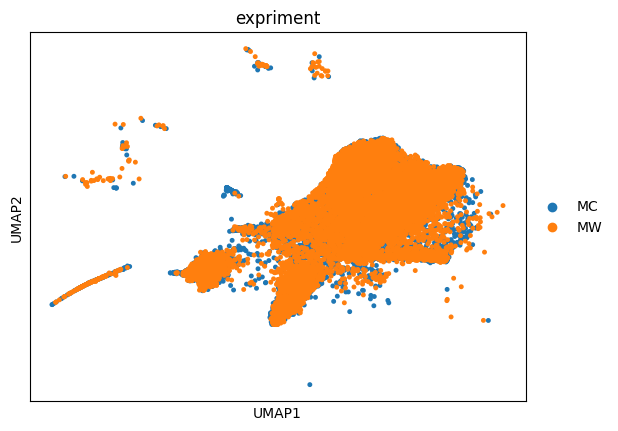

In [20]:
sc.pl.umap(peak_mat, color='expriment', size=50)

In [21]:
df = sc.get.rank_genes_groups_df(peak_mat, group='MC', key='rank_genes_groups',pval_cutoff=0.05)

In [22]:
df.to_csv(f"output/motif/{region}_{celltype}_MC_wilcoxon.csv")
#df.to_csv("output/AMY_neuron_MC_wilcoxon.csv")

In [23]:
#df.sort_values('logfoldchanges',ascending=False).names.str.split(r'[-:]', expand=True).to_csv("output/AMY_neuron_MC_wilcoxon.bed",sep='\t', header=False, index=False) 

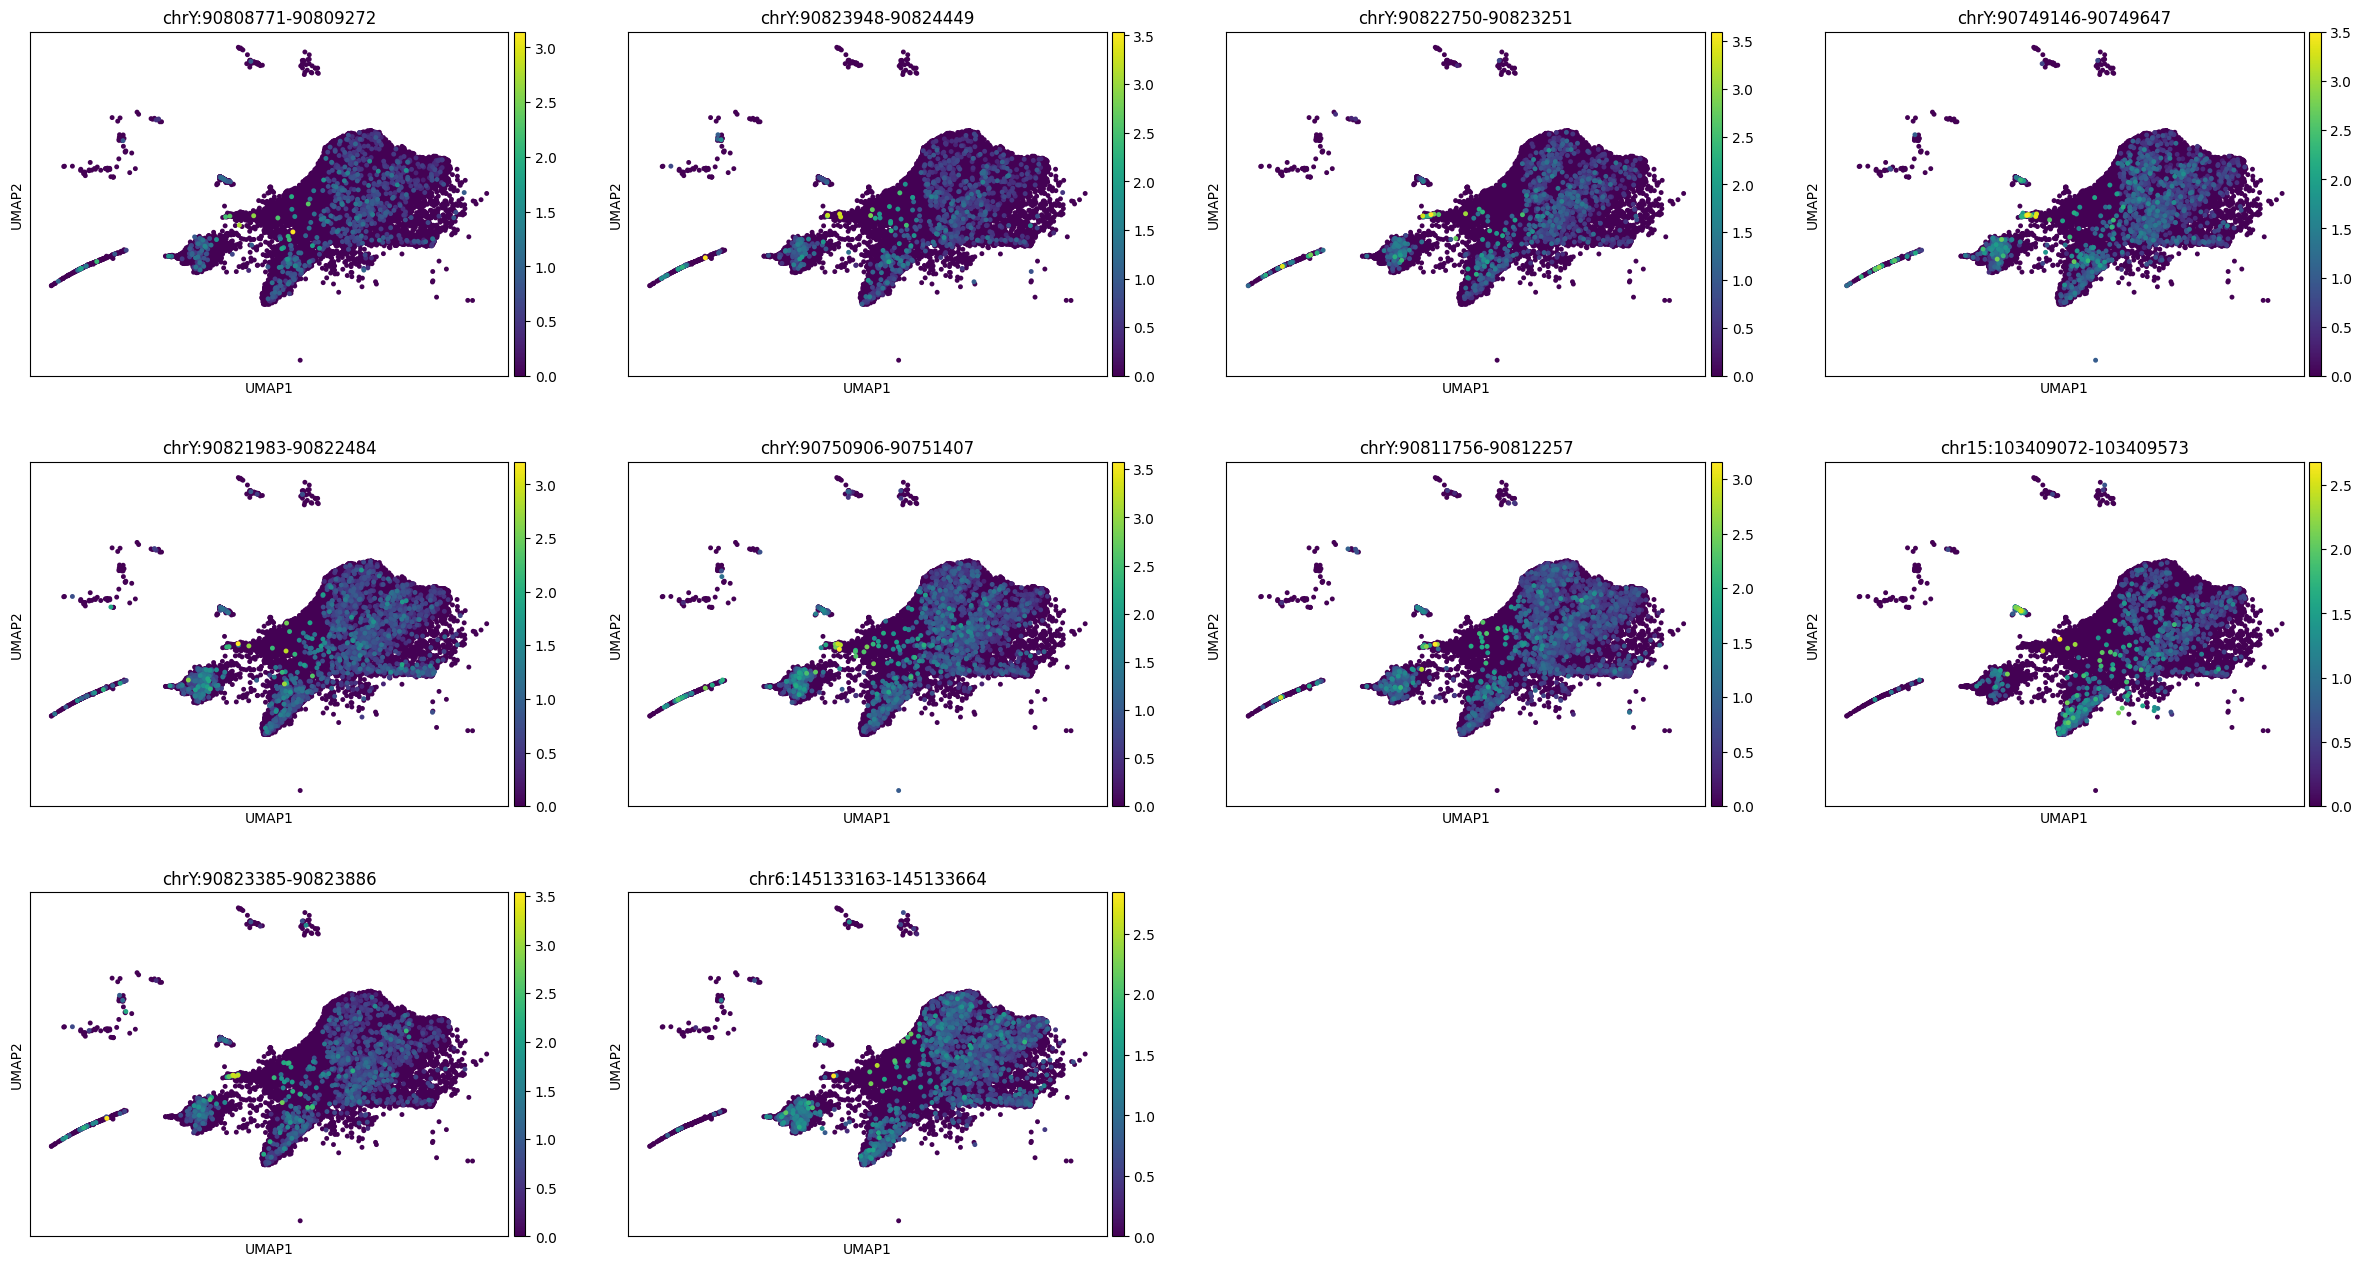

In [24]:
sc.pl.umap(peak_mat, color=df.sort_values('logfoldchanges',ascending=False).head(10).names, size=50)

In [25]:
df_mw = sc.get.rank_genes_groups_df(peak_mat, group='MW', key='rank_genes_groups',pval_cutoff=0.05)

In [26]:
df_mw.to_csv(f"output/motif/{region}_{celltype}_MW_wilcoxon.csv")

In [27]:
# %%time
# marker_peaks = snap.tl.marker_regions(peak_mat, groupby='expriment', pvalue=0.05)


In [28]:
marker_peaks = {"MC": df[df.logfoldchanges>0.1].set_index('names').index,"MW":df_mw[df_mw.logfoldchanges>0.1].set_index('names').index}

In [29]:
from snapatac2._snapatac2 import read_motifs, PyDNAMotif

def cis_bp_mouse(unique: bool = True , path="data/motifdb/Mus_musculus.meme") -> list[PyDNAMotif]:
    motifs = read_motifs(path)
    for motif in motifs:
        motif.name = motif.id.split('+')[0]
    if unique:
        unique_motifs = {}
        for motif in motifs:
            name = motif.name
            if (
                    name not in unique_motifs or 
                    unique_motifs[name].info_content() < motif.info_content()
               ):
               unique_motifs[name] = motif
        motifs = list(unique_motifs.values())
    return motifs


In [30]:
motifs = snap.tl.motif_enrichment(
    motifs=cis_bp_mouse(unique=True,path="data/motifdb/Mus_musculus.meme"),
    regions=marker_peaks,
    genome_fasta=snap.genome.GRCm39,
)


2025-03-05 18:25:24 - INFO - Fetching 4677 sequences ...
2025-03-05 18:25:25 - INFO - Computing enrichment ...
100%|██████████| 790/790 [00:59<00:00, 13.26it/s]


In [31]:
motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_cisbp_motif.csv")

In [32]:
fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
with open(f"output/motif/{base_name}_MC_cisbp_motif.png", 'wb') as f:
    f.write(fig.data)  # Assuming 'im.data' contains the image data


In [33]:
motifs = snap.tl.motif_enrichment(
    motifs=cis_bp_mouse(unique=True,path="data/motifdb/uniprobe_mouse.meme"),
    regions=marker_peaks,
    genome_fasta=snap.genome.GRCm39,
)


2025-03-05 18:26:27 - INFO - Fetching 4677 sequences ...
2025-03-05 18:26:27 - INFO - Computing enrichment ...
100%|██████████| 386/386 [00:43<00:00,  8.81it/s]


In [34]:
fig = snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=4000, interactive=False)
with open(f"output/motif/{base_name}_MC_uniprod_motif.png", 'wb') as f:
    f.write(fig.data)  # Assuming 'im.data' contains the image data


In [35]:
#motifs['MC'].write_csv("output/motif/AMY_neuron_MC_motif_uniprot.csv")
motifs['MC'].write_csv(f"output/motif/{region}_{celltype}_MC_motif_uniprot.csv")